In [208]:
#image analysis
import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
from scipy import optimize
import glob
from PIL import Image
from tqdm import tqdm


%matplotlib ipympl
import ipywidgets as wdg  # Using the ipython notebook widgets
from ipywidgets import interact, interactive, fixed, interact_manual

#%matplotlib inline
from alienlab.regression_func import *

#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename, askdirectory

from VoltageIntensityClass import VoltageIntensity

from skimage.transform import resize

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import random

from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects




def residuals(parameters,x_data,y_observed,func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters,x_data) - y_observed

def platt(parameters, xdata):
    M = parameters[0]
    alpha = parameters[1]
    return M*(1- np.exp(-alpha*xdata/M))

def modele_direct(parameters, x_data):
    a = parameters[0]
    b = parameters[1]
    c = parameters[2]
    d = parameters[3]
    e = parameters[4]
    return (a*x_data +b*np.sqrt(c*I**2+d*I+1)+e)/I

def modele_inverse(parameters, x_data):
    a = parameters[0]
    b = parameters[1]
    c = parameters[2]
    d = parameters[3]
    e = parameters[4]
    f = parameters[5]
    return a*I + b*np.sqrt(c*I**2+d*I+1) + e

In [209]:
#file_path = "ENTER NAME OF THE FILE YOU DROPPED IN THE FILE SECTION HERE"
file_folder = askdirectory(title = 'Select an experiment folder') # pops up a window to select your file
#'G:/DREAM/from_github/PAMFluo/Experiments/2021-08-31_17_51_Ek_video'# 
# uncomment this line if you use this jupyter notebook locally
#'G:/DREAM/from_github/PAMFluo/Experiments/2021-06-24_12_12_Ek_video'
#

In [210]:
show = True #option to output intermediary images in the segmentation process

# Import video file in HQ and select ROI
file_path = file_folder + "/video_2_250.00.tiff"
direc = os.path.split(file_path)[0]

# Initialize plotting tools
g = alienlab.plot.ShowFigure()
g.figsize = (15,7)
g.save_folder = "images"
g.date = False
p = alienlab.plot.PlotFigure()
p.figsize = (15,7)
p.save_folder = "images"
p.date = False

In [211]:
# read the stacked frame. dim = NxHxW (N images in the video, Heigt, Width)

frames_full = skimage.io.imread(file_path)

#frames_full = np.stack([frames_full[:,:,1]]*10, 0) 
#uncomment this line if you have a single RGB image. The [:,:,1] stands for selection of the green channel

FO = FramesOperator(frames_full)
im = normalize(FO.frames[0], 0, 1)
im = grey_to_rgb(im)*255

# CROP
#y, x = alienlab.io.select_roi(np.uint8(im)) #select area of interest
#FO.x = x
#FO.y = y
#FO.crop() #crop image

start_time = time.time()
FO.compute_stats() #compute various statistical values on the frames and the pixels
FO.normalize(0, 1)
print("--- Computed frames statistics in %04f seconds ---" % (time.time() - start_time))

#FO.global_stats: each array has size N, number of frames and represents the stats of each frame
#FO.frames_stats: each array has size FO.x, FO.y and is an image representing the N frames stats overlayed

if show:
    p.title = 'statistics'
    p.xlabel = 'frame number'
    p.ylabel = 'amplitude'
    p.label_list = ['max', 'min', 'mean', 'std']
    fig = p.plotting(np.asarray(FO.inds), [FO.global_stats['max'], 
                        FO.global_stats['min'], 
                        FO.global_stats['mean']])
    p.save_name = 'frames_stats'
    p.saving(fig)

''' IMAGE SEGMENTATION '''

# selection of the frames with high dynamics that will be used for the image segmentation process.
# Let M be the highest value taken by a pixel in all the frames of the video. The frame F is kept for processing only if at
# least one pixel in the frame F has a value above 0.8*M. 
FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.8)


--- Computed frames statistics in 0.131236 seconds ---


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [212]:

plt.figure(figsize = (5, 5))
FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.98) # Select only images with high intensity to increase contrast and lower computation time

imref = FO.frames[FO.selected_inds].sum(axis = 0)
plt.imshow(imref, cmap = 'gray')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [213]:
import copy
L,H,_ = im.shape
mask = copy.copy(im[:,:,0])*0
d = 0
N  = 3
for i in range(L//N):
    for j in range(H//N):
        mask[i*N:(i+1)*N,j*N:(j+1)*N] = d
        d+=1
plt.figure()
plt.imshow(mask)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [214]:
# Collect item labels

# Item time trajectories with overlaps
# create a dictionnary with one entry for each item:
'''
{ '1.0': {'x_coords': np array, x coordinates in HQ}
            'y_coords': np array,  y coordinates in HQ
            'binned_coords': set, couples of (x,y) coordinates in binned video
            'surface': number of pixels in the item in HQ
            'pixel_values': array, size: (N, s) where N is number of frames and s surface
            'mean': array, size N, mean value of the item intensity for each frame
            'std':  array, size N, std value of the item intensity for each frame
            'remains' : True, the item is present in this segmentation step
            }
'2.0': {'x_coords'...
                }
    }
'''
segmented = mask
items = np.unique(segmented) #returns the set of values in items, corresponds to the values of the markers of local_maxima

items_dict = {}
for k in tqdm(list(items)):
    key = str(k)
    items_dict[key] = {}
    x_coords, y_coords = np.nonzero(segmented == k)
    items_dict[key]['x_coords'] = x_coords
    items_dict[key]['y_coords'] = y_coords
    pixel_values = FO.frames[:,x_coords, y_coords]
    items_dict[key]['pixel_values'] = pixel_values
    items_dict[key]['surface'] = pixel_values.shape[1]
    items_dict[key]['mean'] = np.mean(pixel_values, axis = 1)
    items_dict[key]['std'] = np.std(pixel_values, axis = 1)
    items_dict[key]['remains'] = True
    




100%|███████████████████████████████████████████████████████████████████████████| 65044/65044 [01:32<00:00, 701.27it/s]


In [215]:
file_path = file_folder + "/dict_full.npy" # pops up a window to select your file
data = np.load(file_path, allow_pickle=True).item()
voltint = VoltageIntensity()

G:/DREAM/from_github/PAMFluo/Experiments\2021-09-13_14_18_bode_diagram


In [228]:
i = 1
do = {3:10**-2.8,2:10**-1.8, 1:10**-1.2, 0:1}
col = {3:'r', 2:'g',1:'b',0:"k"}
fig, axs = plt.subplots(1,2)
for f in data.keys():
    for amp in data[f].keys():
        if amp >10:
            data_key = data[f][amp]
            video = data_key["video"]
            output = data_key["output"]
            intensity = output[0, :1000000].mean() - output[0, 1000000:].mean()
            fluorescence1 = output[1, 150000:300000].mean() - output[1, 1050000:].mean()
            fluorescence2 = output[1, 700000:9000000].mean() - output[1, 1050000:].mean()
            #axs[0].plot(intensity, fluorescence1/intensity, 'r.')
            #intensity = amp
            #axs[0].plot(intensity, fluorescence2/intensity, 'b.')

            axs[0].plot(intensity, np.mean(video[2:4])/intensity/30, 'r.')
            #axs[1].semilogx(intensity, fluorescence1/intensity, 'b.')

            axs[1].semilogx(intensity, np.mean(video[2:4])/intensity/30, 'r.')
            #axs[1].plot(intensity, np.mean(video[5])/intensity, 'r.')
            #axs[1].plot(intensity, np.mean(video[8])/intensity, 'g.')
            #axs[1].plot(intensity, np.mean(video[11])/intensity, 'k.')

            #plt.plot(voltint.get_intensity_voltage('blue', f, amp/100)*1e6, fluorescence1, '.', color = "b")#col[f])
            #plt.loglog(intensity, fluorescence2/intensity, '.', color = "r")# col[f])
            i += 1


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [128]:
#import mvgavg
#for f in data.keys():
#    for amp in data[f].keys():
#        plt.plot(mvgavg.mvgavg(data[f][amp]['output'][1], 1000), color = col[f])
        
#for f in data.keys():
#    for amp in data[f].keys():
#        plt.semilogy(mvgavg.mvgavg(data[f][amp]['output'][0], 10000))

In [229]:
pos = mask == int(float(13))
portion = imref[np.ix_(pos.any(1), pos.any(0))]
plt.figure()
plt.imshow(pos)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [230]:
file_folder = "G:/DREAM/from_github/PAMFluo/Experiments/2021-08-31_10_45_D2_calib_video"#askdirectory(title = 'Select an experiment folder') # pops up a window to select your file
I_480 = np.load(glob.glob(file_folder + "/*_I_480.npy")[0])


In [231]:
plt.imshow(I_480)
IR = resize(I_480, (L//N, H//N))
plt.figure()
plt.imshow(IR)

Intensity = IR[::-1,::-1].flatten()

print(I_480.mean(), I_480.shape)
print(IR.mean(), IR.shape)

V = VoltageIntensity()

med_image = np.median(Intensity)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

5680.730946400307 (61, 97)
5681.136820293735 (202, 322)
G:/DREAM/from_github/PAMFluo/Experiments\2021-09-13_14_18_bode_diagram


In [232]:
"""
FD_tot = []
x0 = [4e-4, 4e-3]
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

ek_values = {}
M_values = {}
A3 = {}
algae_list = list(items_dict.keys())[1:]

imask= copy.copy(imref)*0
imtau= copy.copy(imref)*0

    
    
for P in [15]:#[len(algae_list)]:#[8, 10, 12, 15, 18, 20, 25, 30, 35, 40, 60, 90, 120, 180, 200, 250, 300, 400, 500, 600, 700]:
    ek_values[P] = []
    M_values[P] = []
    A3[P] = []
    #for i, algae in enumerate(algae_list):
    for i, algae in enumerate(random.sample(algae_list, P)):#
        #if int(algae):# in ['1', '80', '400', '250']:
            i = 0
            I = []
            FD = []
            for f in data.keys():
                for amp in data[f].keys():

                    #x_coords =  items_dict['0']['x_coords']
                    #y_coords =  items_dict['0']['y_coords']
                    #video = data[f][amp]['video']
                    #output = data[f][amp]['output']
                    #threshold = np.mean(video[0, x_coords, y_coords])

                    x_coords =  items_dict[algae]['x_coords']
                    y_coords =  items_dict[algae]['y_coords']
                    video = data[f][amp]['video']
                    output = data[f][amp]['output']
                    algae_fluo = np.sum(video[8:11, x_coords, y_coords]) ###!!!!!!!!!!!!!!!mean or sum
                    if amp>10:
                        output_intensity = np.mean(output[0,:1000000])
                        I.append(output_intensity)
                        #I.append(1e6*voltint.get_intensity_MPPC('blue', f,np.mean(output[0,:1000000])))#np.mean(output[0]))
                        FD.append(algae_fluo)
                        i += 1
                        #plt.plot(np.mean(video[:,x_coords, y_coords], axis = 1))
                    
                    else:
                        i+=1
            A3[P].append(algae_fluo/output_intensity)
            I = np.array(I)
            FD = np.array(FD)#/max(FD) 
            FD_tot.append(FD)
            FD_norm = FD/FD.max()
            parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (0,1e3),
                                            args = (I, FD_norm/(I*Intensity[i]), platt))
            (M, ek) = parameters_estimated.x
            ek_values[P].append(ek)
            M_values[P].append(M)
            axs[0][1].plot(I, platt(parameters_estimated.x, I), '-')
            axs[0][0].plot(I, FD, '--o')
            axs[0][0].set_xlim(0,0.15)
            axs[0][0].set_ylim(0,22)

            axs[0][0].set_title("FD")
            axs[0][1].plot(I, FD_norm/(I*Intensity[i]), 'o')
            axs[0][1].set_title("FD/I")
            pos = mask == int(float(algae))
            #portion = imref[np.ix_(pos.any(1), pos.any(0))]
        
            
            imtau[pos] = M/ek

            axs[0][2].imshow(portion)
            imask[pos]=imref[pos]
            axs[1][0].imshow(imask)
            plt.ylim(0,10)
            
            axs[1,1].imshow(imtau)

    ek = np.array(ek_values[P])
    M = np.array(M_values[P])
    indices = (M/ek)<1e2
    plt.scatter(P, np.std(M[indices]/ek[indices]))
plt.figure()    
plt.imshow(imtau)
"""

'\nFD_tot = []\nx0 = [4e-4, 4e-3]\nfig, axs = plt.subplots(2, 3, figsize=(20, 10))\n\nek_values = {}\nM_values = {}\nA3 = {}\nalgae_list = list(items_dict.keys())[1:]\n\nimask= copy.copy(imref)*0\nimtau= copy.copy(imref)*0\n\n    \n    \nfor P in [15]:#[len(algae_list)]:#[8, 10, 12, 15, 18, 20, 25, 30, 35, 40, 60, 90, 120, 180, 200, 250, 300, 400, 500, 600, 700]:\n    ek_values[P] = []\n    M_values[P] = []\n    A3[P] = []\n    #for i, algae in enumerate(algae_list):\n    for i, algae in enumerate(random.sample(algae_list, P)):#\n        #if int(algae):# in [\'1\', \'80\', \'400\', \'250\']:\n            i = 0\n            I = []\n            FD = []\n            for f in data.keys():\n                for amp in data[f].keys():\n\n                    #x_coords =  items_dict[\'0\'][\'x_coords\']\n                    #y_coords =  items_dict[\'0\'][\'y_coords\']\n                    #video = data[f][amp][\'video\']\n                    #output = data[f][amp][\'output\']\n                 

In [233]:
algae_list = list(items_dict.keys())

I_image_tot = []
FD_tot = []
i = 0
for algae in tqdm(algae_list):
    I = []
    FD = []
    I_image = []
    for f in data.keys():
        for amp in data[f].keys():
            if amp > 10:
                    image_intensity = Intensity * V.get_intensity_voltage('blue', f, amp/100)*1e6/med_image

                    x_coords =  items_dict[algae]['x_coords']
                    y_coords =  items_dict[algae]['y_coords']
                    video = data[f][amp]['video']
                    output = data[f][amp]['output']
                    algae_fluo = np.mean(video[8:11, x_coords, y_coords]) ###!!!!!!!!!!!!!!!mean or sum
                    output_intensity = np.mean(output[0,:1000000])
                    I.append(output_intensity)
                    I_image.append(image_intensity[i])
                    FD.append(algae_fluo)
    i += 1
    I_image = np.array(I_image)
    I_image_tot.append(I_image)
    I = np.array(I)
    FD = np.array(FD)#/np.array(FD).max()
    FD_tot.append(FD)

100%|██████████████████████████████████████████████████████████████████████████| 65044/65044 [1:24:39<00:00, 12.80it/s]


In [182]:
x0 = [8e-1, 2e-2]
def get_fit(FD, I_image):    

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (0,1e8),
                                args = (I_image, FD/I, platt))
    
    return np.array(parameters_estimated.x)
plt.figure()
ind = 201
FD = FD_tot[ind]
I_image = I_image_tot[ind]
plt.plot(I_image, FD/I)
plt.plot(I_image, platt(get_fit(FD, I_image), I_image))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [135]:
I_image

array([  1.46528322,   3.80207869,   6.26315561,   8.71979845,
        12.67987841,  32.90141785,  54.19843108,  75.45707384,
        45.35199844, 117.67818291, 193.85100409, 269.88658599])

In [184]:

params = Parallel(n_jobs = -1 )(delayed(get_fit)(FD_tot[i], I_image_tot[i]) for i in range(len(FD_tot)))

params = np.array(params)
M_values = params[:,0]
ek_values = params[:,1]

In [189]:
ek_values

array([11507.75833027,  1380.99412564,  1278.97162507, ...,
         867.82796804,   445.75733885,   586.53430728])

In [206]:
#ekk = np.array([np.mean(ek)] + ek_values[15]).reshape((L//N,H//N))
#mm = np.array([np.mean(M)] + M_values[15]).reshape((L//N,H//N))
ekk = ek_values.reshape((L//N,H//N))
mm = M_values.reshape((L//N,H//N))

def clip(input_image, low = 10, high = 60):
    im = copy.copy(input_image)
    m = np.median(im)
    im[im<np.percentile(im, low)]=np.percentile(im, low)
    im[im>np.percentile(im, high)]=np.percentile(im, high)
    return im

fig, axs = plt.subplots(2,2)


axs[0][0].imshow(clip(ekk))
axs[1][0].imshow(mm)
axs[0][1].imshow(mm/ekk)
axs[1][1].imshow(imref)

np.percentile(im, 10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

3.4931506849315066

In [207]:

# Create a random image
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(imref)
axs[0].axis('off')

# Create and display textarea widget
txt = wdg.Textarea(
    value='',
    placeholder='',
    description='event:',
    disabled=False
)
display(txt)
coords = []

# Define a callback function that will update the textarea
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    txt.value = str(event)#"x= %d, y = %d"%(ix, iy)

    global coords
    coords.append((ix, iy))
    
    algae_ind = int(mask[iy.astype(int), ix.astype(int)])
    if algae_ind != 0:

        decay = FD_tot[algae_ind]
        intensity = I_image_tot[algae_ind]
        #decay = decay/intensity

        pred = get_fit(decay, intensity)
        axs[1].plot(intensity, platt(pred, intensity), label = pred[0]/pred[1])
        axs[1].plot(intensity, decay/I, '.')
        axs[1].legend()
        plt.tight_layout()
# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Textarea(value='', description='event:', placeholder='')

In [97]:
iy

11.611680679097226

In [140]:
plt.figure()
    
algae_ind =200#int(mask[iy.astype(int), ix.astype(int)])
if algae_ind != 0:

    decay = FD_tot[algae_ind]
    intensity = I_image_tot[algae_ind]

    params = get_fit(decay, intensity)
    plt.plot(intensity, platt(params, intensity), label = params[1])
    plt.plot(intensity, decay/I, '.')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [76]:
params

array([329534.48923685, 119305.0297762 ])

In [43]:
i

1440

In [53]:
np.save("G:/DREAM/from_github/PAMFluo/Figures/imref_%d.npy"%N, imref)
np.save("G:/DREAM/from_github/PAMFluo/Figures/imtau_%d.npy"%N, clip(mm/ekk))

In [54]:
import matplotlib.pyplot as plt
a = np.load("G:/DREAM/from_github/PAMFluo/Figures/imref_3.npy")
b = np.load("G:/DREAM/from_github/PAMFluo/Figures/imtau_3.npy")
plt.show(a)
plt.figure()
plt.show(b)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [187]:
plt.figure()
plt.hist(clip(mm/ekk, high = 99, low = 1).flatten())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([24635.,  5312., 12015., 11329.,  6004.,  2663.,  1249.,   612.,
          351.,   874.]),
 array([7.21974678e-06, 2.22123240e+00, 4.44245758e+00, 6.66368276e+00,
        8.88490794e+00, 1.11061331e+01, 1.33273583e+01, 1.55485835e+01,
        1.77698087e+01, 1.99910338e+01, 2.22122590e+01]),
 <BarContainer object of 10 artists>)

In [ ]:
u = np.array(FD_tot)
FD_m = np.mean(u, axis = 0)
I_m = np.copy(I)
indices = (FD_m < 250)*(FD_m>0.4)*(I_m>5e-4)*(I_m<2.8)
I_m = I_m[indices]
FD_m = FD_m[indices]
plt.plot(I_m, FD_m/I_m, '.')

In [ ]:
u.shape

In [ ]:
test = []
measure = []
for f in data.keys():
    for amp in data[f].keys():
        output = data[f][amp]['output']
        mppc = np.mean(output[0])
        #test.append(voltint.get_MPPC_voltage('blue', f, amp/100))
        test.append(voltint.get_intensity_MPPC('blue', f, mppc ))
        measure.append(mppc)
#plt.loglog(test, '.')
plt.loglog(test, measure, '.')

In [24]:
for P in list(ek_values.keys())[::-1]: 
    ek = np.array(ek_values[P])
    M = np.array(M_values[P])
    indices = (M/ek)<1e2
    plt.hist(M[indices]/ek[indices], bins = 100)
    #plt.hist(ek[indices], bins = 100)

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [ ]:
for P in list(ek_values.keys())[::-1]: 
    a3 = np.array(A3[P])
    ek = np.array(ek_values[P])
    M = np.array(M_values[P])
    indices = (M/ek)<1e2
    plt.scatter(P, np.std(M[indices]/ek[indices]))
    #plt.scatter(P, np.sqrt(P)/2000, color = 'b')
    #plt.scatter(P, np.std(a3))

In [ ]:
FD_mppc = []
I_mppc = []
i = 0
x0 = [0.001, 0.0005/200]
for f in data.keys():
    for amp in data[f].keys():
        if i > 0:
            data_key = data[f][amp]
            video = data_key["video"]
            output = data_key["output"]
            intensity = output[0, :1000000].mean()# - output[0, 1000000:].mean()
            fluorescence1 = output[1, 150000:300000].mean() - output[1, 1050000:].mean()
            fluorescence2 = output[1, 700000:9000000].mean() - output[1, 1050000:].mean()
            fluorescence = output[1, :1000000].mean()
            #plt.plot(intensity, fluorescence2/intensity, '.')
            #intensity = voltint.get_intensity_MPPC('blue', f, np.mean(output[0,:1000000]))*1e6
            #plt.loglog(intensity, fluorescence2/intensity, '.', color = "r")# col[f])
            i += 1
            I_mppc.append(intensity)
            FD_mppc.append(fluorescence)
        
        else: 
            i+= 1

I_mppc = np.array(I_mppc)
FD_mppc = np.array(FD_mppc)

indices = (FD_mppc < 2.8)*(FD_mppc>5e-4)*(I_mppc>5e-4)*(I_mppc<2.8)

I_mppc = np.array(I_mppc)[indices]
FD_mppc = np.array(FD_mppc)[indices]
parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e5,1e5),
                                        args = (I_mppc, FD_mppc/I_mppc, platt))
(M, ek) = parameters_estimated.x
plt.loglog(I_mppc, platt((M,ek), I_mppc))
plt.loglog(I_mppc, FD_mppc/I_mppc, '.')


In [ ]:
I_mppc

In [ ]:
#plt.plot(I, FD)
plt.plot(I_mppc, FD_mppc)

In [ ]:
plt.loglog(I_mppc, FD_mppc, ".")


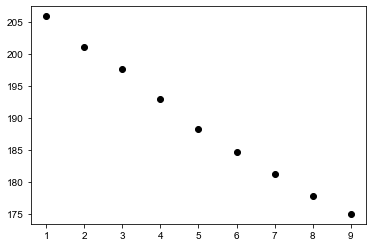

In [42]:
ek_values =[]
x0 = [2, 0.2]

for algae in list(items_dict.keys())[100:101]:
    i = 0
    I = {}
    FD = {}
    for k in range(1,10):
        I[k] = []
        FD[k] = []
        for f in [1,0]:#data.keys():
            for amp in data[f].keys():
                if i > 3:
                    x_coords =  items_dict[algae]['x_coords']
                    y_coords =  items_dict[algae]['y_coords']
                    video = data[f][amp]['video']
                    output = data[f][amp]['output']
                    algae_fluo = np.mean(video[k, x_coords, y_coords])
                    I[k].append(np.mean(output[0]))
                    FD[k].append(algae_fluo)
                    i += 1

                else:
                    i+=1
        #plt.plot(I[k], np.array(FD[k])/np.array(I[k]), label = str(k))#
        plt.scatter(k, FD[k][-1]/I[k][-1], color = 'k')
        #plt.scatter(k, FD[k][-9]/I[k][-9], color = 'b', label = 9)

#plt.legend()

In [43]:
list(items_dict.keys())[10]

'10'